# Customer Product Models

In [1]:

import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.metrics  # use existing libraries!
from tqdm import tqdm
import math
import sklearn.datasets
import sklearn.ensemble
import sklearn.tree
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pandas.api.types import CategoricalDtype
from scipy.sparse import csr_matrix
from sklearn.metrics import confusion_matrix
import numpy

from sklearn.metrics import accuracy_score

from sklearn.calibration import CalibratedClassifierCV

numpy.set_printoptions(threshold=10)

              
              

In [2]:
# score function: binary cross entropy loss
def score_yp(y, p): # y, p are numpy arrays
    return sklearn.metrics.log_loss(y, p)

In [3]:
# score wrapper, for data frames. we need this when using the `truth` data frame
def score(x, y): # x, y are data frames
    xy = pd.merge(x, y, on=["customer", "product", "week"])
    assert xy.shape[0] == x.shape[0]
    return score_yp(xy["y"].values, xy["probability"].values)

## Input

In [4]:
# INPUT
training_week = 88  # for model training
validation_week = 89  # for model and baseline validation
test_week = 90  # for the final prediction (one week in the future, beyond our data)
target_customers = list(range(2000))
target_products = list(range(250))

## Load data

In [5]:
baskets = pd.read_parquet("baskets.parquet")
# we only keep the 2000 customers required for the test set
# a complex model might require more data, e.g., see Boosted Tree model in Gabel & Timoshenko (2021)
baskets = baskets[baskets["customer"]<2000]
baskets.head()

,week,customer,product,price
0,0,0,71,629
1,0,0,91,605
2,0,0,116,715
3,0,0,123,483
4,0,0,157,592


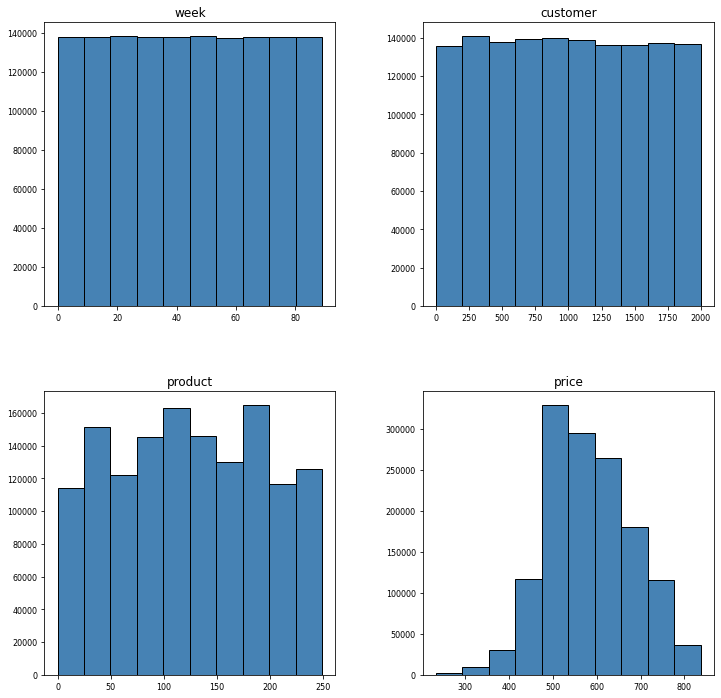

In [5]:
baskets.hist(bins = 10, color = 'steelblue', edgecolor = 'black', linewidth = 1.0,
        xlabelsize = 8, ylabelsize = 8, grid = False, figsize = (12,12))
plt.show()

In [6]:
discounts = pd.read_parquet('coupons.parquet')
discounts = discounts[discounts["customer"]<2000]
discounts.head(10)

,week,customer,product,discount
0,0,0,35,35
1,0,0,193,40
2,0,0,27,30
3,0,0,177,35
4,0,0,5,30
5,0,1,99,35
6,0,1,101,30
7,0,1,7,15
8,0,1,115,30
9,0,1,18,25


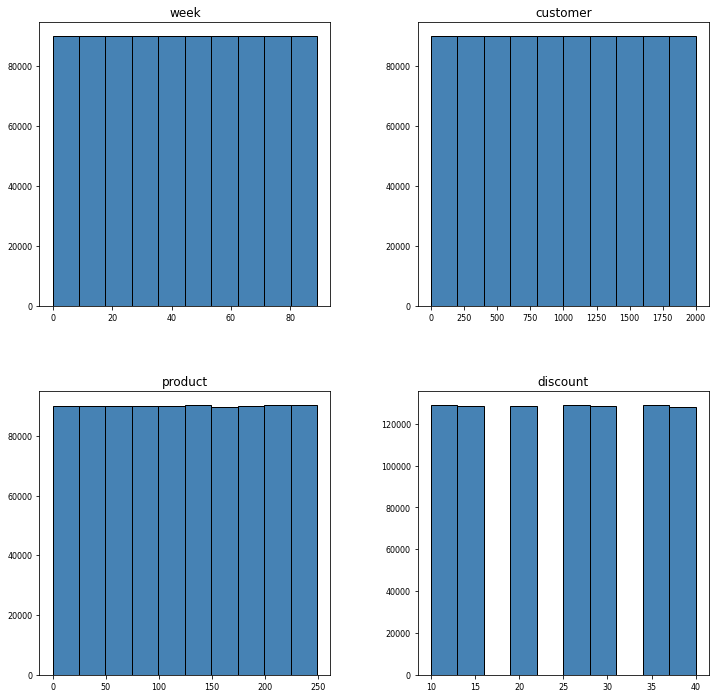

In [7]:
discounts.hist(bins = 10, color = 'steelblue', edgecolor = 'black', linewidth = 1.0,
        xlabelsize = 8, ylabelsize = 8, grid = False, figsize = (12,12))
plt.show()

In [8]:
prediction_index = pd.read_parquet("prediction_index.parquet")
prediction_index.head()

,week,customer,product
0,90,0,0
1,90,0,1
2,90,0,2
3,90,0,3
4,90,0,4


In [9]:
n_weeks = baskets.week.nunique()
print(n_weeks)

90


<br>

## SOLUTION 1: Descriptive feature (past purchase rates) = Baseline

Now we have predictions, but we have no idea how good this baseline is.  So let's do the following:
1. construct a ground truth data set
1. do a proper train/validation split
1. predict purchase probabilities using our baseline
1. evaluate the predictions vs. the base

### Validation

In [10]:
# function to define target variable for all customer-product combinations (in a given week)
def build_target(baskets, week):

    baskets_week = baskets[baskets["week"] == week][
        ["week", "customer", "product"]
    ].reset_index(drop=True)
    baskets_week["y"] = 1

    df = pd.DataFrame(
        {
            "week": week,
            "customer": np.repeat(target_customers, len(target_products), axis=0),
            "product": target_products * len(target_customers),
        }
    )

    df = df.merge(baskets_week, on=["week", "customer", "product"], how="left")
    df["y"] = df["y"].fillna(0).astype(int)

    return df

<br>

## SOLUTION 2: simple machine learning model   

### Example for constructing the features

In [11]:
def build_frequency_feature(baskets, week_start, week_end, feature_name):
    # subset baskets
    baskets_subset = baskets[(baskets["week"] >= week_start) & (baskets["week"] <= week_end)]

    purchase_frequency_ij = ((baskets_subset.groupby(["customer", "product"])[["week"]].count()
                              / baskets_subset.week.nunique())
                             .rename(columns={"week": feature_name}).reset_index())

    return purchase_frequency_ij

In [12]:
def price_per_basket_feature(baskets, week, feature_name):
    baskets_sub = baskets[baskets["week"] == week]


    basket_price = baskets_sub.groupby(['customer'])[['price']].sum().rename(columns={"price": feature_name}).reset_index()
    new = baskets_sub.merge(basket_price,on = ['customer'], how = 'left')
    new[feature_name] = new.apply(lambda x: round(x['price']/x[feature_name],4),axis = 1)
    new = new.drop(['week','price'],axis = 1)
    return new
    

In [13]:
def mean_price_per_basket_feature(baskets, week, feature_name):
    baskets_sub = baskets[baskets["week"] == week]


    basket_price = baskets_sub.groupby(['customer'])[['price']].mean().rename(columns={"price": feature_name}).reset_index()
    new = baskets_sub.merge(basket_price,on = ['customer'], how = 'left')
    new[feature_name] = new.apply(lambda x: round(x['price']/x[feature_name],4),axis = 1)
    new = new.drop(['week','price'],axis = 1)
    return basket_price

In [14]:
def customer_category(baskets, week_start, week_end, feature_name):
    basket_price = baskets[(baskets["week"] >= week_start) & (baskets["week"] <= week_end)].groupby(['customer','week'])[['price']].sum().rename(columns={"price": 'basket price'}).reset_index().fillna(0)
    basket_price[feature_name] = basket_price['basket price'].apply(lambda x: 1 if x>=5000 else 0)
    heavy_spender_frequency = basket_price.groupby(['customer'])[[feature_name]].sum()/basket_price['week'].nunique()
    
    return heavy_spender_frequency


In [8]:
def pairs(baskets_sub):
    n_products = 250
    bas = baskets_sub.groupby(['customer','product'])[['week']].apply(lambda x:1).reset_index()
    truth = np.zeros((n_products, n_products), dtype=int)

    for b in bas['customer'].to_list():
        for j in bas[bas['customer'] == b]['product']:
            for i in bas[bas['customer'] == b]['product']:
                truth[i, j] += 1

    assert np.all(truth == truth.T)
    np.fill_diagonal(truth, 0)
    return truth

In [17]:
baskets_sub = baskets[baskets["week"] == 1 ]
baskets_sub

,week,customer,product,price
764812,1,0,71,629
764813,1,0,91,605
764814,1,0,130,613
764815,1,0,157,592
764816,1,0,167,582
...,...,...,...,...
780129,1,1999,86,481
780130,1,1999,103,539
780131,1,1999,158,566
780132,1,1999,192,549


In [18]:
bas = baskets_sub.groupby(['customer','product'])[['week']].apply(lambda x:1).reset_index()
bas


,customer,product,0
0,0,71,1
1,0,91,1
2,0,130,1
3,0,157,1
4,0,167,1
...,...,...,...
15317,1999,86,1
15318,1999,103,1
15319,1999,158,1
15320,1999,192,1


In [9]:
n_products = 250
ini = np.zeros((n_products, n_products), dtype=int)
for i in tqdm(range(5)):
    baskets_sub = baskets[baskets["week"] == i ]
    p = pairs(baskets_sub)
    ini = np.add(ini, p)

100%|██████████| 5/5 [02:29<00:00, 29.80s/it]


In [10]:
product_category = {}
j = 0
k = 0
for i in range(250):
    
    if ini[j,i] == 0:
        product_category[i] = k
    else:
        k+=1
        product_category[i] = k
        j = i
        
category_product_map = pd.DataFrame({"product": list(range(250))})
category_product_map['category'] = category_product_map['product'].apply(lambda x: product_category[x])

In [19]:
def category_customer_frequency(baskets, week_start, week_end, feature_name):
    
    baskets_train = baskets[(baskets["week"] >= week_start) & (baskets["week"] <= week_end)].merge(category_product_map,on = ['product'], how = 'left')
    purchase_frequency_ic = (
        (
            baskets_train.groupby(["customer", "category"])[
                ["week"]
            ].count()  # number of weeks with purchase
            / n_weeks  # number of weeks
        )
        .rename(columns={"week": feature_name})
        .reset_index()
    )
    return purchase_frequency_ic

In [20]:
def discounted_item_bought_frequency(baskets, week_start, week_end, feature_name):
    
    baskets_sub = baskets[(baskets["week"] >= week_start) & (baskets["week"] <= week_end)]
    discounts_sub = discounts[(discounts["week"] >= week_start) & (discounts["week"] <= week_end)].merge(baskets_sub, on = ['week','customer','product']).drop(['price','discount'],axis = 1)
    discount_frequency_ij = ((discounts_sub.groupby(["customer", "product"])[["week"]].count()
                              / discounts_sub.week.nunique())
                             .rename(columns={"week": feature_name}).reset_index())
    return discount_frequency_ij

### Example for building the base table

In [21]:
def build_base_table(baskets, week):
    # target variable (product purchase)
    # consider using multiple weeks for training! more data might lead to better results.
    # also, different weeks might have different information.
    y = build_target(baskets, week)
    # features
    # note how features are computed on data BEFORE the target week
    x_1 = build_frequency_feature(baskets, -1, week - 1, "frequency_full")
    x_3 = build_frequency_feature(baskets, week - 7, week - 1, "frequency_l7")
    x_4 = discounts[discounts['week'] == week-1].drop('week',axis = 1).reset_index(drop = True)
    x_4['discount'] = x_4['discount'].apply(lambda x: x/100)
    x_5 = category_customer_frequency(baskets, -1, week - 1, "category_frequency_full")
    x_6 = customer_category(baskets, -1, week - 1, "customer category")
    x_7 = discounted_item_bought_frequency(baskets, -1, week - 1, "discount_purchase_frequency_full")
    x_9 = discounted_item_bought_frequency(baskets, week - 7, week - 1, "discount_purchase_frequency_l7") 
    x_10 = build_frequency_feature(discounts, -1, week - 1,'discount_given_frequency_full')
    #x_11 = build_frequency_feature(discounts, week - 7, week - 1,'discount_given_frequency_l30')
    x_12 = build_frequency_feature(discounts, week - 7, week - 1,'discount_given_frequency_l7')




    

    base_table_yx = (
        y.merge(x_1, on=["customer", "product"], how="left")
        .merge(x_3, on=["customer", "product"], how="left")
        .merge(x_4, on=["customer", "product"], how="left")
        .merge(category_product_map, on = ['product'],how = 'left')
        .merge(x_5, on=["customer", "category"], how="left")
        .merge(x_6, on=["customer"], how="left")
        .merge(x_7, on=["customer", "product"], how="left")
        .merge(x_9, on=["customer", "product"], how="left")
        .merge(x_10, on=["customer", "product"], how="left")
        #.merge(x_11, on=["customer", "product"], how="left")
        .merge(x_12, on=["customer", "product"], how="left")
        


        .fillna(0)
    )
    base_table_yx['product_category_probability'] = base_table_yx.apply(lambda x: x['frequency_full']/x['category_frequency_full'] if x['category_frequency_full'] != 0 else 0,axis = 1)
    #base_table_yx['discount multiplied'] = base_table_yx.apply(lambda x: x['discount']*x['discount_given_frequency_full'],axis = 1)
    
    return base_table_yx

# Out of Sample validate
Main model is Random forest and Ada Boost is just for extra (Got very close)

In [22]:
training_features = ["frequency_full", "frequency_l7", 'product_category_probability','discount','discount_purchase_frequency_full']
week = 79
metrics = {'baseline':[],'bin':[],'rf':[],'ada':[]}
metrics1 = {'baseline':[],'bin':[],'rf':[],'ada':[]}
for i in tqdm(range(10)):
    base_t = build_base_table(baskets, week+i)
    y = base_t["y"].values 
    X = base_t[training_features].values
    log_reg = sklearn.linear_model.LogisticRegression(verbose = 10,max_iter=1200000).fit(X, y)
    log_reg_baseline = sklearn.linear_model.LogisticRegression(max_iter=1200000).fit(base_t['frequency_full'].values.reshape(-1, 1), y)
    adaboost = sklearn.ensemble.AdaBoostClassifier(n_estimators=50, algorithm="SAMME",random_state = 0)
    calibrated = CalibratedClassifierCV(adaboost, method='sigmoid', cv=5).fit(X,y)
    rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100,random_state = 0,criterion = 'entropy',max_depth = 5).fit(X,y)
    
    base_tr = build_base_table(baskets, week+i+1)
    
    Y_val = base_tr["y"].values
    X_val = base_tr[training_features].values # purchase frequencies
    base_tr["probability_baseline"] = log_reg_baseline.predict_proba(base_tr['frequency_full'].values.reshape(-1,1))[:, 1]
    base_tr["probability_bin"] = log_reg.predict_proba(X_val)[:, 1]
    base_tr["probability_ada"] = calibrated.predict_proba(X_val)[:, 1]
    base_tr["probability_rf"] = rf.predict_proba(X_val)[:, 1]
    
    base_tr["pred_baseline"] = log_reg_baseline.predict(base_tr['frequency_full'].values.reshape(-1,1))
    base_tr["pred_bin"] = log_reg.predict(X_val)
    base_tr["pred_ada"] = calibrated.predict(X_val)
    base_tr["pred_rf"] = rf.predict(X_val)
    
    
    
    metrics['baseline'].append(score_yp(base_tr["y"].values, base_tr["probability_baseline"].values))
    metrics['bin'].append(score_yp(base_tr["y"].values, base_tr["probability_bin"].values))
    metrics['rf'].append(score_yp(base_tr["y"].values, base_tr["probability_rf"].values))
    metrics['ada'].append(score_yp(base_tr["y"].values, base_tr["probability_ada"].values))

    metrics1['baseline'].append(accuracy_score(base_tr["y"].values, base_tr["pred_baseline"].values))
    metrics1['bin'].append(accuracy_score(base_tr["y"].values, base_tr["pred_bin"].values))
    metrics1['rf'].append(accuracy_score(base_tr["y"].values, base_tr["pred_rf"].values))
    metrics1['ada'].append(accuracy_score(base_tr["y"].values, base_tr["pred_ada"].values))





  0%|          | 0/10 [00:00<?, ?it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
 10%|█         | 1/10 [00:37<05:38, 37.56s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
 20%|██        | 2/10 [01:14<04:59, 37.45s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
 30%|███       | 3/10 [01:52<04:22, 37.50s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapse

In [23]:
metrics

{'baseline': [0.08995255826635384,
  0.08941306303182316,
  0.08944181290785011,
  0.08942608017023292,
  0.08926616728689359,
  0.09039501406948706,
  0.09000717639507985,
  0.0903586479456785,
  0.09024880117259622,
  0.08974706688855824],
 'bin': [0.08619970050178441,
  0.08591534398762381,
  0.085954248333992,
  0.0857292442769792,
  0.08574547472946226,
  0.08671437468645621,
  0.08635685798297676,
  0.08668312676562782,
  0.08650091502542748,
  0.08605595661070019],
 'rf': [0.07824106464471571,
  0.0780448858660846,
  0.07764467227083231,
  0.07796150694173146,
  0.07761554808189357,
  0.07853823636581464,
  0.07845833849278222,
  0.07838560109442233,
  0.07855597924743078,
  0.07777178122254413],
 'ada': [0.07829237350503492,
  0.07829080590345475,
  0.07807277469754598,
  0.07826158299938923,
  0.07785321046071791,
  0.07881720740304764,
  0.07871388269602668,
  0.07877313207046775,
  0.07854163610783844,
  0.07810809847030652]}

In [24]:
final_metrics = []
final_metrics_acc = []

for i in metrics:
    final_metrics.append(i+': ')
    final_metrics.append(sum(metrics[i])/len(metrics[i]))
    final_metrics_acc.append(i+': ')
    final_metrics_acc.append(sum(metrics1[i])/len(metrics1[i]))


final_metrics

['baseline: ',
 0.08982563881345536,
 'bin: ',
 0.08618552429010302,
 'rf: ',
 0.07812176142282519,
 'ada: ',
 0.07837247043138298]

In [25]:
final_metrics_acc

['baseline: ',
 0.9717144,
 'bin: ',
 0.9716802000000001,
 'rf: ',
 0.9717826000000003,
 'ada: ',
 0.9719498]

# In Sample

In [26]:
in_sample_val_week = 88
base_table_train_sample = build_base_table(baskets, in_sample_val_week)
base_table_train_sample

,week,customer,product,y,frequency_full,frequency_l7,discount,category,category_frequency_full,customer category,discount_purchase_frequency_full,discount_purchase_frequency_l7,discount_given_frequency_full,discount_given_frequency_l7,product_category_probability
0,88,0,0,0,0.000000,0.0,0.00,0,0.088889,0.477273,0.000000,0.0,0.000000,0.000000,0.000000
1,88,0,1,0,0.000000,0.0,0.00,0,0.088889,0.477273,0.000000,0.0,0.022727,0.000000,0.000000
2,88,0,2,0,0.000000,0.0,0.00,0,0.088889,0.477273,0.000000,0.0,0.022727,0.000000,0.000000
3,88,0,3,0,0.000000,0.0,0.15,0,0.088889,0.477273,0.000000,0.0,0.022727,0.142857,0.000000
4,88,0,4,0,0.090909,0.0,0.00,0,0.088889,0.477273,0.000000,0.0,0.034091,0.000000,1.022727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,88,1999,245,0,0.125000,0.0,0.00,24,0.611111,0.534091,0.022727,0.0,0.045455,0.142857,0.204545
499996,88,1999,246,0,0.000000,0.0,0.00,24,0.611111,0.534091,0.000000,0.0,0.022727,0.142857,0.000000
499997,88,1999,247,0,0.000000,0.0,0.00,24,0.611111,0.534091,0.000000,0.0,0.034091,0.000000,0.000000
499998,88,1999,248,0,0.000000,0.0,0.00,24,0.611111,0.534091,0.000000,0.0,0.022727,0.000000,0.000000


In [27]:
Y_val_sample = base_table_train_sample["y"].values
X_val_sample = base_table_train_sample[training_features].values 
base_table_train_sample["probability_baseline"] = log_reg_baseline.predict_proba(base_table_train_sample['frequency_full'].values.reshape(-1,1))[:, 1]
base_table_train_sample["probability_bin"] = log_reg.predict_proba(X_val_sample)[:, 1]
base_table_train_sample["probability_ada"] = calibrated.predict_proba(X_val_sample)[:, 1]
base_table_train_sample["probability_rf"] = rf.predict_proba(X_val_sample)[:, 1]

base_table_train_sample["predict"] = log_reg.predict(X_val_sample)

In [28]:
score_yp(
    base_table_train_sample["y"].values,
    base_table_train_sample["probability_baseline"].values
)

0.09024745865648576

In [29]:
score_yp(
    base_table_train_sample["y"].values,
    base_table_train_sample["probability_bin"].values
)

0.08649803978325613

In [30]:
score_yp(
    base_table_train_sample["y"].values,
    base_table_train_sample["probability_rf"].values
)

0.07823183323906718

In [31]:
score_yp(
    base_table_train_sample["y"].values,
    base_table_train_sample["probability_ada"].values
)

0.07871929657934673

### Test: Produce final result (week 90)

In [32]:
train_week = 89
base_table_train = build_base_table(baskets, train_week)
base_table_train

,week,customer,product,y,frequency_full,frequency_l7,discount,category,category_frequency_full,customer category,discount_purchase_frequency_full,discount_purchase_frequency_l7,discount_given_frequency_full,discount_given_frequency_l7,product_category_probability
0,89,0,0,0,0.000000,0.0,0.0,0,0.088889,0.47191,0.000000,0.0,0.000000,0.000000,0.000000
1,89,0,1,0,0.000000,0.0,0.0,0,0.088889,0.47191,0.000000,0.0,0.022472,0.000000,0.000000
2,89,0,2,0,0.000000,0.0,0.2,0,0.088889,0.47191,0.000000,0.0,0.033708,0.142857,0.000000
3,89,0,3,0,0.000000,0.0,0.0,0,0.088889,0.47191,0.000000,0.0,0.022472,0.142857,0.000000
4,89,0,4,0,0.089888,0.0,0.0,0,0.088889,0.47191,0.000000,0.0,0.033708,0.000000,1.011236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,89,1999,245,1,0.123596,0.0,0.0,24,0.611111,0.52809,0.022472,0.0,0.044944,0.142857,0.202247
499996,89,1999,246,0,0.000000,0.0,0.0,24,0.611111,0.52809,0.000000,0.0,0.022472,0.142857,0.000000
499997,89,1999,247,0,0.000000,0.0,0.0,24,0.611111,0.52809,0.000000,0.0,0.033708,0.000000,0.000000
499998,89,1999,248,0,0.000000,0.0,0.0,24,0.611111,0.52809,0.000000,0.0,0.022472,0.000000,0.000000


In [33]:
y = base_table_train["y"].values 
X = base_table_train[training_features].values
log_reg = sklearn.linear_model.LogisticRegression(verbose = 10,max_iter=1200000).fit(X, y)
log_reg_baseline = sklearn.linear_model.LogisticRegression(max_iter=1200000).fit(base_table_train['frequency_full'].values.reshape(-1, 1), y)
adaboost = sklearn.ensemble.AdaBoostClassifier(n_estimators=50, algorithm="SAMME",random_state = 0)
calibrated = CalibratedClassifierCV(adaboost, method='sigmoid', cv=5).fit(X,y)
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100,random_state = 0,criterion = 'entropy',max_depth = 5).fit(X,y)
    

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


In [34]:
print(training_features)
log_reg.intercept_, log_reg.coef_

['frequency_full', 'frequency_l7', 'product_category_probability', 'discount', 'discount_purchase_frequency_full']


(array([-4.82931608]),
 array([[ 6.94540014, -0.74189687,  2.26285388, -0.12763008,  4.1790473 ]]))

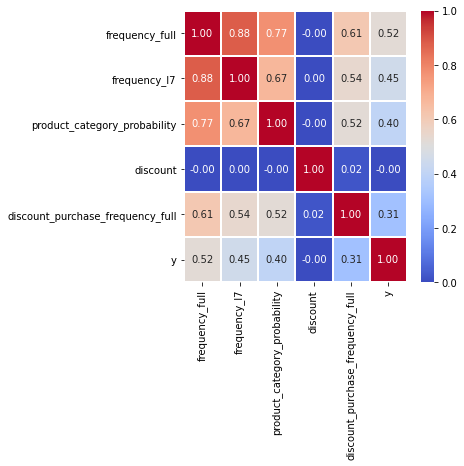

In [35]:
feature_space = training_features.copy()
feature_space.append('y')
corr = base_table_train[feature_space].corr()
fig, ax = plt.subplots(figsize=(5,5))
hm = sns.heatmap(round(corr,2), annot=True, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)

In [36]:
test_week = 90
base_table_test = build_base_table(baskets, test_week)
base_table_test

,week,customer,product,y,frequency_full,frequency_l7,discount,category,category_frequency_full,customer category,discount_purchase_frequency_full,discount_purchase_frequency_l7,discount_given_frequency_full,discount_given_frequency_l7,product_category_probability
0,90,0,0,0,0.000000,0.000000,0.0,0,0.088889,0.477778,0.000000,0.0,0.000000,0.000000,0.000000
1,90,0,1,0,0.000000,0.000000,0.0,0,0.088889,0.477778,0.000000,0.0,0.022222,0.000000,0.000000
2,90,0,2,0,0.000000,0.000000,0.0,0,0.088889,0.477778,0.000000,0.0,0.033333,0.142857,0.000000
3,90,0,3,0,0.000000,0.000000,0.0,0,0.088889,0.477778,0.000000,0.0,0.022222,0.142857,0.000000
4,90,0,4,0,0.088889,0.000000,0.0,0,0.088889,0.477778,0.000000,0.0,0.033333,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,90,1999,245,0,0.133333,0.142857,0.0,24,0.622222,0.533333,0.022222,0.0,0.044444,0.142857,0.214286
499996,90,1999,246,0,0.000000,0.000000,0.3,24,0.622222,0.533333,0.000000,0.0,0.033333,0.285714,0.000000
499997,90,1999,247,0,0.000000,0.000000,0.0,24,0.622222,0.533333,0.000000,0.0,0.033333,0.000000,0.000000
499998,90,1999,248,0,0.000000,0.000000,0.0,24,0.622222,0.533333,0.000000,0.0,0.022222,0.000000,0.000000


In [37]:
X_test = base_table_test[training_features].values

base_table_test["probability"] = rf.predict_proba(X_test)[:, 1]

base_table_test["probability"]

prediction_index = prediction_index.merge(base_table_test[['week','customer','product','probability']],on = ['week','customer','product'], how = 'left')

prediction_index.to_parquet('Predictions_week_90')

prediction_index

,week,customer,product,probability
0,90,0,0,0.001276
1,90,0,1,0.001276
2,90,0,2,0.001276
3,90,0,3,0.001276
4,90,0,4,0.111203
...,...,...,...,...
499995,90,1999,245,0.138735
499996,90,1999,246,0.000361
499997,90,1999,247,0.001276
499998,90,1999,248,0.001276


# EDA

In [38]:
baskets.head()

,week,customer,product,price
0,0,0,71,629
1,0,0,91,605
2,0,0,116,715
3,0,0,123,483
4,0,0,157,592


In [39]:
baskets.describe()

,week,customer,product,price
count,1.378720e+06,1.378720e+06,1.378720e+06,1.378720e+06
mean,4.447746e+01,9.972110e+02,1.250727e+02,5.843381e+02
std,2.597662e+01,5.762501e+02,6.970123e+01,9.743281e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,2.340000e+02
25%,2.200000e+01,4.990000e+02,6.600000e+01,5.060000e+02
50%,4.400000e+01,9.930000e+02,1.230000e+02,5.790000e+02
75%,6.700000e+01,1.496000e+03,1.890000e+02,6.540000e+02
max,8.900000e+01,1.999000e+03,2.490000e+02,8.370000e+02


<AxesSubplot:>

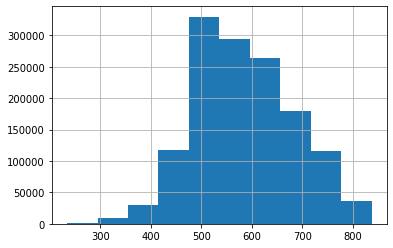

In [40]:
baskets['price'].hist()

4476.615638509496
1436.840873321052


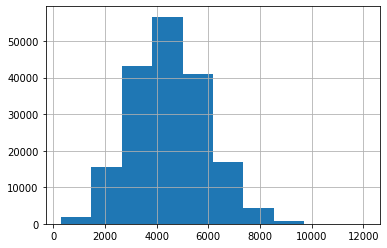

In [41]:
baskets.groupby(['customer','week'])[['price']].sum()['price'].hist()

#average Basket price and sd
print(baskets.groupby(['customer','week'])[['price']].sum()['price'].mean())
print(baskets.groupby(['customer','week'])[['price']].sum()['price'].std())

In [42]:
#average products per basket
baskets.groupby(['customer','week'])[['product']].nunique().mean()

product    7.661003
dtype: float64

In [43]:
discounts.head()

,week,customer,product,discount
0,0,0,35,35
1,0,0,193,40
2,0,0,27,30
3,0,0,177,35
4,0,0,5,30


In [44]:
discounts.describe()

,week,customer,product,discount
count,900000.000000,900000.000000,900000.000000,900000.000000
mean,44.500000,999.500000,124.590253,24.995317
std,25.979173,577.350518,72.201282,9.999064
min,0.000000,0.000000,0.000000,10.000000
25%,22.000000,499.750000,62.000000,15.000000
50%,44.500000,999.500000,125.000000,25.000000
75%,67.000000,1499.250000,187.000000,35.000000
max,89.000000,1999.000000,249.000000,40.000000


In [45]:
discounts.groupby(['customer','week'])[['product']].nunique().mean()

product    5.0
dtype: float64

In [46]:
redemption = discounts.merge(baskets, on = ['week','customer','product']).drop(['price','discount'],axis = 1)

In [47]:
redemption_rate = 54247/900000
redemption_rate

0.06027444444444444

In [48]:
df_all = build_target(baskets,0)


for i in range(1,90):
    df_all = df_all.append(build_target(baskets,i),ignore_index=True)
    

In [49]:
df_all

,week,customer,product,y
0,0,0,0,0
1,0,0,1,0
2,0,0,2,0
3,0,0,3,0
4,0,0,4,0
...,...,...,...,...
44999995,89,1999,245,1
44999996,89,1999,246,0
44999997,89,1999,247,0
44999998,89,1999,248,0


array([[<AxesSubplot:title={'center':'y'}>]], dtype=object)

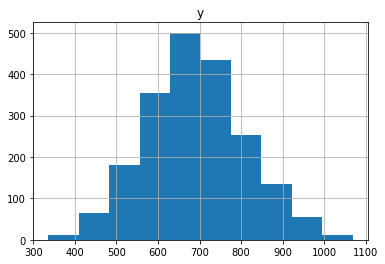

In [50]:
df_all.groupby('customer')[['y']].sum().hist()

array([[<AxesSubplot:title={'center':'y'}>]], dtype=object)

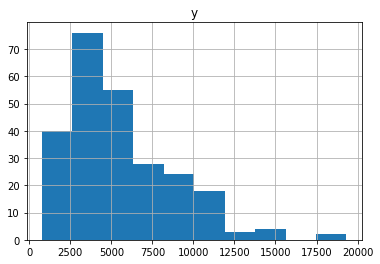

In [51]:
df_all.groupby('product')[['y']].sum().hist()

<AxesSubplot:>

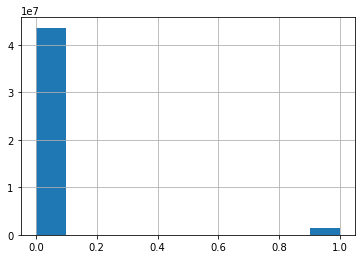

In [52]:
df_all.y.hist()